<a href="https://colab.research.google.com/github/teruyo14/Classification-of-CIFAR10-with-Major-CNNs-and-Visualization-with-t-SNE/blob/main/Classification_of_CIFAR10_with_SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Papers: Squeeze-and-Excitation Networks  
https://arxiv.org/pdf/1709.01507.pdf

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import copy
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)  # Use nn.Conv2d instead of nn.Linear
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w  # New broadcasting feature from v0.2!

        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
            )

        # SE layers
        self.fc1 = nn.Conv2d(planes, planes//16, kernel_size=1)
        self.fc2 = nn.Conv2d(planes//16, planes, kernel_size=1)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))

        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w

        out += shortcut
        return out


class SENet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x, return_embed=False):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        if return_embed:
            return out
        out = self.linear(out)
        return out

    def get_device(self):
        return self.linear.weight.device

    def copy(self):
        return copy.deepcopy(self)

In [ ]:
def SENet18():
    return SENet(PreActBlock, [2,2,2,2])

In [ ]:
model = SENet18()
model.to(device)

SENet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00008, weight_decay=5e-4)

In [ ]:
def plot_t_sne(data_loader, model,num_samples):
    model.eval()

    # Formatting data for t-SNE
    x = []
    y = []
    for imgs, labels in data_loader:
        with torch.no_grad():
            imgs = imgs.to(model.get_device())

            # Extracting features
            embeddings = model(imgs, return_embed=True)

            x.append(embeddings.to('cpu'))
            y.append(labels.clone())

    x = torch.cat(x)
    y = torch.cat(y)

    # To Numpy Array
    x = x.numpy()
    y = y.numpy()

    # Extract a specified number of samples
    x = x[:num_samples]
    y = y[:num_samples]

    # Apply t-SNE
    t_sne = TSNE(n_components=2, random_state=0)
    x_reduced = t_sne.fit_transform(x)

    # Set color and marker for each label
    cmap = plt.get_cmap("tab10")
    markers = ['4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D']

    # Plot data
    plt.figure(figsize=(20, 15))
    for i, cls in enumerate(data_loader.dataset.classes):
        plt.scatter(x_reduced[y == i, 0], x_reduced[y == i, 1],
                    c=[cmap(i / len(data_loader.dataset.classes))],
                    marker=markers[i], s=500, alpha=0.6, label=cls)
    plt.axis('off')

    plt.legend(bbox_to_anchor=(1, 1), fontsize=24, framealpha=0)
    plt.title("Model:SENet18", fontsize = 70, y = -0.1)
    plt.show()

epoch: 1, loss: 1.2983502120599484, acc: 0.5264715552330017,      val loss: 0.9071808705885951, val acc: 0.6780151724815369
epoch: 2, loss: 0.8528579873719889, acc: 0.6992562413215637,      val loss: 0.7221139725119161, val acc: 0.7479033470153809
epoch: 3, loss: 0.6913609962507615, acc: 0.760336697101593,      val loss: 0.6890548601889381, val acc: 0.7697683572769165
epoch: 4, loss: 0.591876884501711, acc: 0.7950855493545532,      val loss: 0.5770017936968574, val acc: 0.802515983581543
epoch: 5, loss: 0.5300827408382242, acc: 0.8154990673065186,      val loss: 0.5151551023078041, val acc: 0.8225838541984558
epoch: 6, loss: 0.4770017302596867, acc: 0.8347528576850891,      val loss: 0.5198387655492027, val acc: 0.8169928193092346
epoch: 7, loss: 0.4321179226498457, acc: 0.8492082357406616,      val loss: 0.49181901199368244, val acc: 0.8333665728569031
epoch: 8, loss: 0.4010440662112361, acc: 0.8611444234848022,      val loss: 0.4397622296890131, val acc: 0.8496405482292175
epoch: 9, 

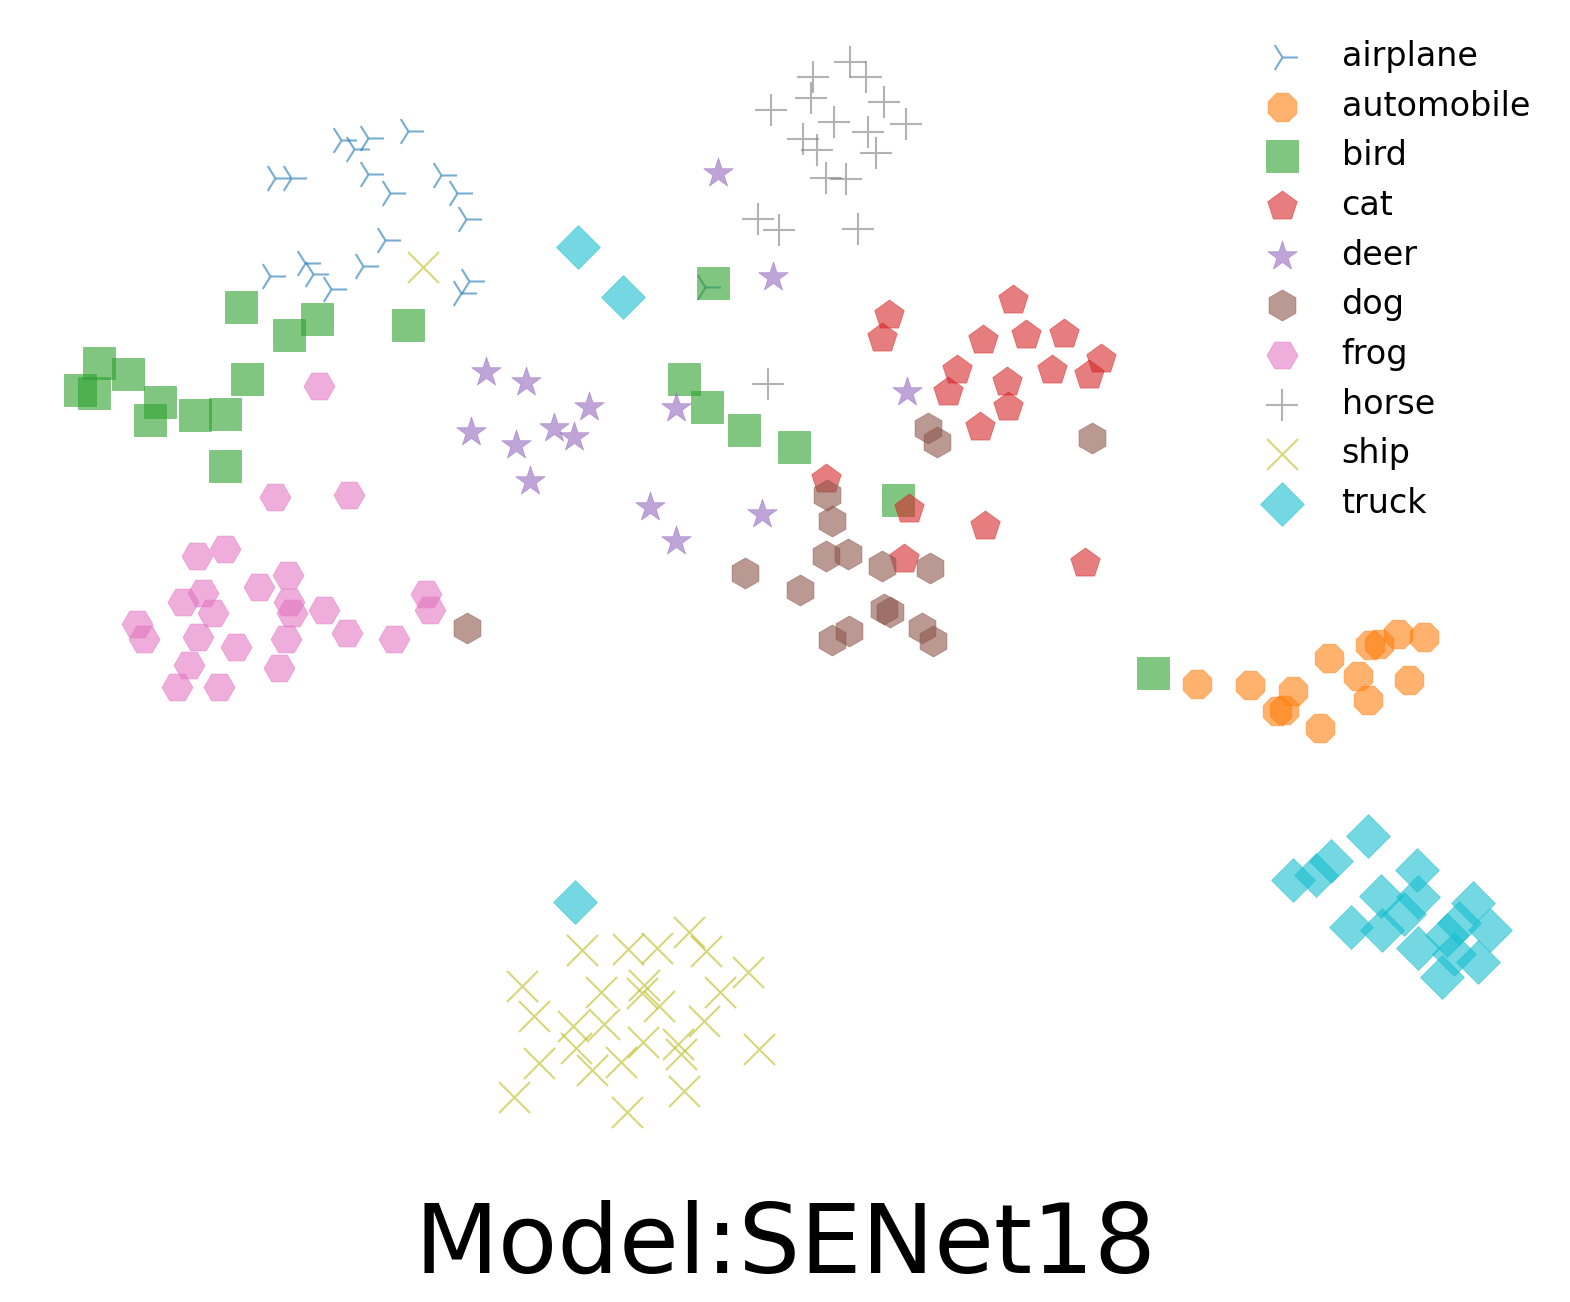

In [ ]:
num_epochs = 20
num_samples = 200
losses = []
accs = []
val_losses = []
val_accs = []
val_acc_best = 0.0
model_best = None
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc.item())
    #
    # validation loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    model.eval()
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc.item())
    if val_running_acc > val_acc_best:
            val_acc_best = val_loss
            model_best = model.copy()
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch+1, running_loss, running_acc, val_running_loss, val_running_acc))

# Plot distribution of features using t-SNE
plot_t_sne(validation_dataloader, model_best, num_samples)

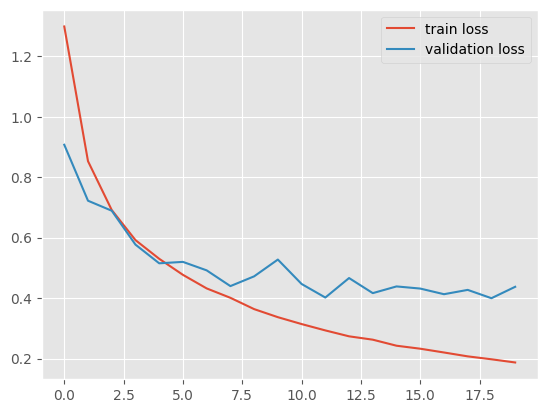

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

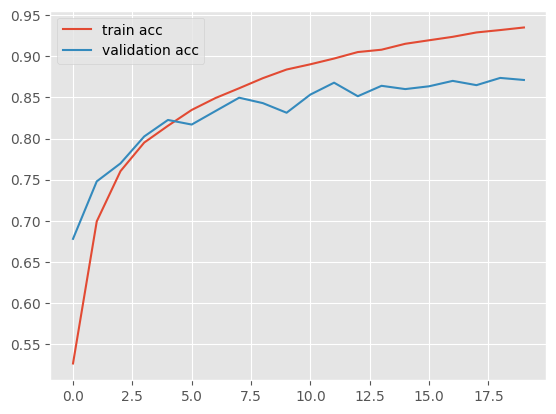

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.legend()